<a href="https://colab.research.google.com/github/Ilurusheshasai/sql-injection-detection-using-bert/blob/main/Copy_of_Bert_Iter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers --upgrade
!pip install torch --upgrade
!pip install accelerate --upgrade

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/sqliv2_mod.csv')  # replace with your file path

# Display the first few rows of the dataframe
a = (df['Label'] == 1).sum()
print(a)

# Display the first few rows of the dataframe
a = (df['Label'] == 0).sum()
print(a)

df.shape

11455
22990


(34445, 2)

In [ ]:
#!pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split

# Ensure that 'query' column is of string type
df['Sentence'] = df['Sentence'].astype(str)


# Splitting the data into training, validation, and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize and create datasets
train_dataset = CustomDataset(train_df['Sentence'].tolist(), train_df['Label'].tolist(), tokenizer)
val_dataset = CustomDataset(val_df['Sentence'].tolist(), val_df['Label'].tolist(), tokenizer)
test_dataset = CustomDataset(test_df['Sentence'].tolist(), test_df['Label'].tolist(), tokenizer)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['Label']), y=train_df['Label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/734/result_bert_iter',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/734/result_bert_iter/logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_metrics = compute_metrics(test_results)
print(test_metrics)

# Get the confusion matrix
cm = confusion_matrix(test_results.label_ids, test_results.predictions.argmax(-1))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000400,0.015906,0.996952,0.995428,0.998689,0.992188
2,0.000000,0.014943,0.998113,0.997173,0.999129,0.995226
3,0.000000,0.006648,0.999129,0.998698,0.998698,0.998698


{'accuracy': 0.9982580926114095, 'f1': 0.99734395750332, 'precision': 0.9977856510186005, 'recall': 0.9969026548672566}


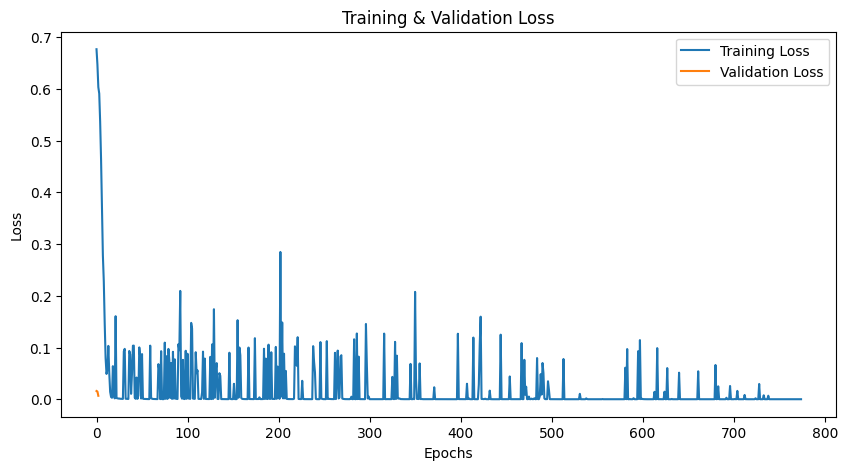

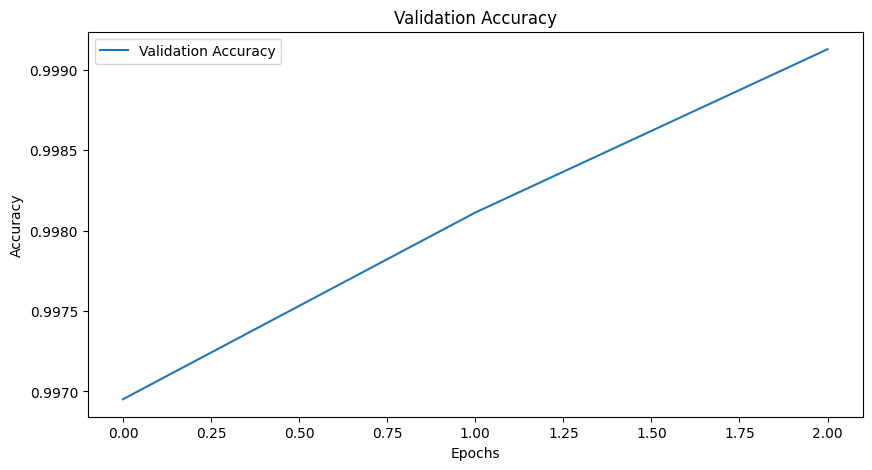

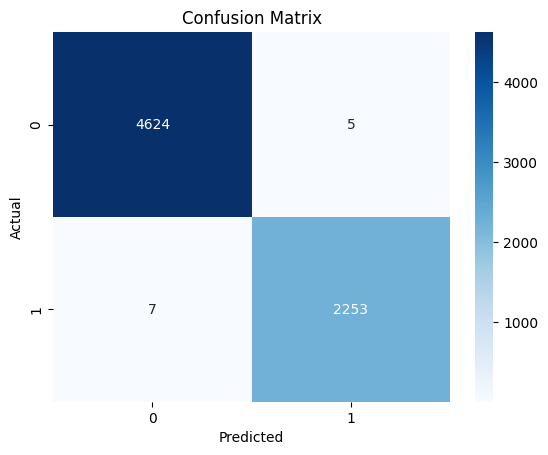

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the loss and accuracy from trainer.state.log_history
log_history = trainer.state.log_history

training_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

from transformers import BertForSequenceClassification

# Load the saved best model
model_path = '/content/drive/MyDrive/734/result_bert_iter/checkpoint-7752'  # Replace 'XXXX' with the checkpoint number
model = BertForSequenceClassification.from_pretrained(model_path)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Initialize the tokenizer and load your fine-tuned model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example texts to classify
texts = ['SELECT * FROM users', 'Please drop an option', 'Please Select an option', '%2A%28%7C%28mail%3D%2A%29%29', "' or 1=1", '?', 'DROP TABLE users; --', 'I am Sai', 'I am Sai Select * from V']

# Tokenize and prepare the inputs
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)

# Iterate over predictions and print results
for text, prediction in zip(texts, predictions):
    predicted_class = torch.argmax(prediction).item()
    print(f"Text: {text}\nPredicted class: {'SQL Injection' if predicted_class == 1 else 'No Injection'}\n")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Text: SELECT * FROM users
Predicted class: SQL Injection

Text: Please drop an option
Predicted class: No Injection

Text: Please Select an option
Predicted class: No Injection

Text: %2A%28%7C%28mail%3D%2A%29%29
Predicted class: SQL Injection

Text: ' or 1=1
Predicted class: SQL Injection

Text: ?
Predicted class: SQL Injection

Text: DROP TABLE users; --
Predicted class: SQL Injection

Text: I am Sai
Predicted class: No Injection

Text: I am Sai Select * from V
Predicted class: No Injection



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Example texts to classify
texts = ['SELECT * FROM users','select an Alter table', 'hi There',"; 'Drop me at my house and ; select * from table a car;'", "|| Drop me at my house", 'Whats up','Please drop an option',"'or 1=1", 'Please Select an option', '%2A%28%7C%28mail%3D%2A%29%29', "' or 1=1", '?', 'DROP TABLE users; --', 'I am Sai', 'I am Sai Select * from V']
#texts = []
# Tokenize and prepare the inputs
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)

# Iterate over predictions and print results
for text, prediction, probability in zip(texts, predictions, probabilities):
    predicted_class = torch.argmax(prediction).item()
    print(f"Text: {text}\nPredicted class: {'SQL Injection' if predicted_class == 1 else 'No Injection'}")
    print(f"Probability of being an SQL Injection: {probability[1].item()}\n")
# Tokenize texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")



Text: SELECT * FROM users
Predicted class: SQL Injection
Probability of being an SQL Injection: 0.9999847412109375

Text: select an Alter table
Predicted class: No Injection
Probability of being an SQL Injection: 6.460036729549756e-06

Text: hi There
Predicted class: No Injection
Probability of being an SQL Injection: 5.067598522146e-06

Text: ; 'Drop me at my house and ; select * from table a car;'
Predicted class: SQL Injection
Probability of being an SQL Injection: 0.9999768733978271

Text: || Drop me at my house
Predicted class: No Injection
Probability of being an SQL Injection: 0.44598498940467834

Text: Whats up
Predicted class: No Injection
Probability of being an SQL Injection: 5.264605533739086e-06

Text: Please drop an option
Predicted class: No Injection
Probability of being an SQL Injection: 6.736618615832413e-06

Text: 'or 1=1
Predicted class: SQL Injection
Probability of being an SQL Injection: 0.9999877214431763

Text: Please Select an option
Predicted class: No Injecti